In [9]:
# pip install prophet
# pip install plotly
# pip install plotly --upgrade
# pip install nbformat>=4.2.0

In [2]:
import os

import pandas as pd
import requests
import numpy as np
from sklearn.metrics import mean_absolute_error
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

print(__version__)  # need 1.9.0 or greater

init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

6.5.0


In [3]:
df = pd.read_csv("wiki_machine_learning.csv", sep=" ")
df = df[df["count"] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [4]:
df.shape
df.date = pd.to_datetime(df.date)
plotly_df(df.set_index("date")[["count"]])

In [5]:
from prophet import Prophet

c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [6]:
predictions = 30

df = df[["date", "count"]]
df.columns = ["ds", "y"]
train_df = df[:-predictions].copy()

13:27:16 - cmdstanpy - INFO - Chain [1] start processing
13:27:17 - cmdstanpy - INFO - Chain [1] done processing


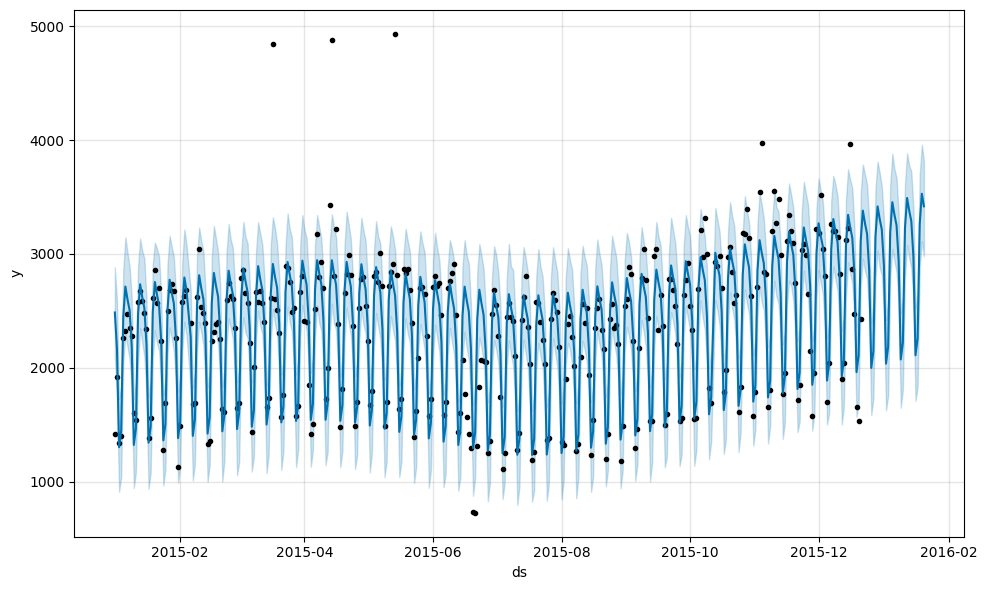

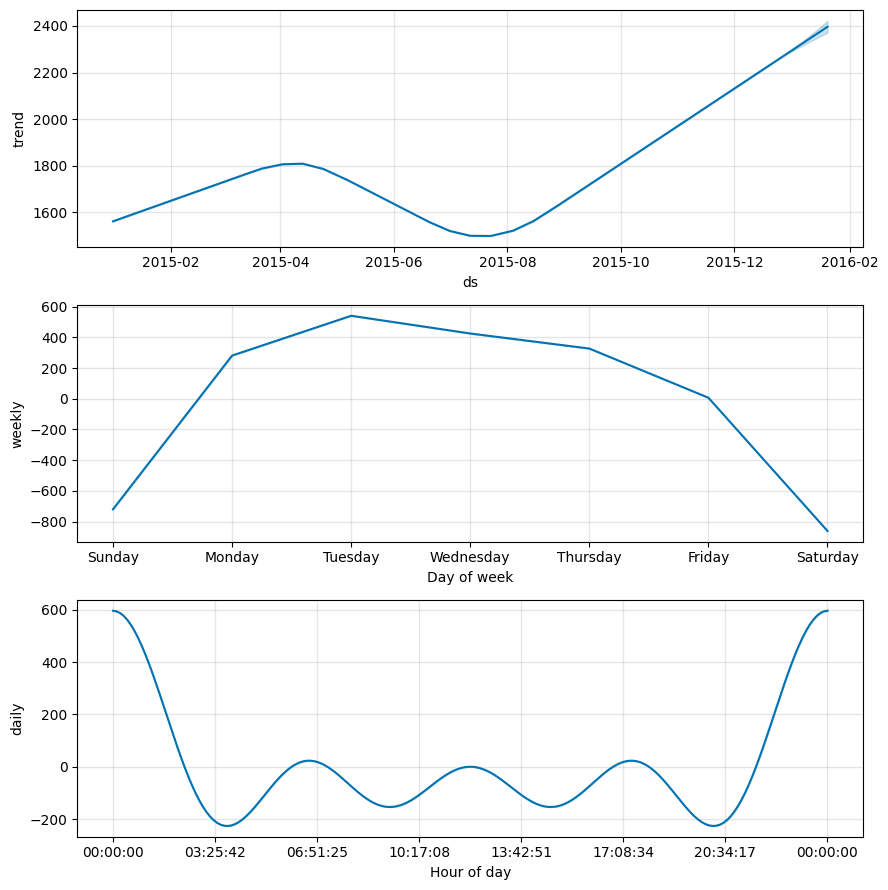

In [7]:
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False
)

model.fit(train_df)

future = model.make_future_dataframe(periods=predictions, freq='D')

forecast = model.predict(future)

fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

In [8]:
# Вопрос 1
forecast_20jan = forecast[forecast['ds'] == '2015-01-20']
print(f"Прогноз на 20 января: {round(forecast_20jan['yhat'].iloc[0])}")

Прогноз на 20 января: 2753


In [9]:
test_df = df[-predictions:].copy()
test_predictions = forecast[-predictions:]
test_df = test_df.merge(test_predictions[['ds', 'yhat']], on='ds')

print(test_df)

           ds     y         yhat
0  2015-12-22  2469  3380.040768
1  2015-12-23  2292  3269.783289
2  2015-12-24  1671  3176.923563
3  2015-12-25  1227  2861.725505
4  2015-12-26  1367  1998.600795
5  2015-12-27  1373  2145.200504
6  2015-12-28  2181  3152.326999
7  2015-12-29  2162  3417.084864
8  2015-12-30  2107  3306.827385
9  2015-12-31  1590  3213.967659
10 2016-01-01  1159  2898.769601
11 2016-01-02  1704  2035.644891
12 2016-01-03  1724  2182.244600
13 2016-01-04  3180  3189.371095
14 2016-01-05  3180  3454.128960
15 2016-01-06  3186  3343.871481
16 2016-01-07  3055  3251.011755
17 2016-01-08  2874  2935.813697
18 2016-01-09  1674  2072.688987
19 2016-01-10  1873  2219.288696
20 2016-01-11  3083  3226.415191
21 2016-01-12  3319  3491.173056
22 2016-01-13  3145  3380.915577
23 2016-01-14  3164  3288.055851
24 2016-01-15  2743  2972.857793
25 2016-01-16  1644  2109.733083
26 2016-01-17  1836  2256.332791
27 2016-01-18  2983  3263.459287
28 2016-01-19  3389  3528.217151
29 2016-01

In [10]:
# Вопрос 2
def calculate_mape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100

mape = calculate_mape(test_df['y'], test_df['yhat'])
print(f"MAPE: {mape:.2f}%")

MAPE: 34.21%


In [11]:
# Вопрос 3
mae = mean_absolute_error(test_df['y'], test_df['yhat'])
print(f"MAE: {mae:.2f}")

MAE: 593.65


In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller 
from scipy import stats

In [13]:
# Вопрос 4
result = adfuller(train_df['y'])
print(f"p-value: {result[1]:.4f}")

p-value: 0.1074


In [14]:
# Вопрос 5
import itertools

train_data = train_df.set_index('ds')['y']

standard_models = [
    ((1, 1, 1), (1, 1, 1, 7)),
    ((1, 1, 1), (0, 1, 1, 7)),
    ((1, 1, 0), (0, 1, 1, 7)),
    ((0, 1, 1), (1, 1, 0, 7)),
    ((1, 1, 0), (1, 1, 0, 7)),
]

results_list = []

for order, seasonal_order in standard_models:
    try:
        model = sm.tsa.statespace.SARIMAX(
            train_data,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False
        )
        
        results = model.fit(disp=True, maxiter=200)
        
        results_list.append({
            'order': order,
            'seasonal_order': seasonal_order,
            'aic': results.aic,
            'bic': results.bic,
            'model': results
        })
        
    except Exception as e:
        print(f"Ошибка: {e}")

if results_list:
    best_result = min(results_list, key=lambda x: x['aic'])
    
    print("\n" + "="*60)
    print("РЕЗУЛЬТАТЫ:")
    print("="*60)
    
    for i, res in enumerate(sorted(results_list, key=lambda x: x['aic'])):
        print(f"{i+1}. SARIMAX{res['order']}x{res['seasonal_order']} - AIC: {res['aic']:.2f}, BIC: {res['bic']:.2f}")
    
    print("\n" + "="*60)
    print("ЛУЧШАЯ МОДЕЛЬ:")
    print("="*60)
    print(f"Параметры: SARIMAX{best_result['order']}x{best_result['seasonal_order']}")
    print(f"AIC: {best_result['aic']:.2f}")
    print(f"BIC: {best_result['bic']:.2f}")
else:
    print("Модели не сработали")

c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. foreca


РЕЗУЛЬТАТЫ:
1. SARIMAX(1, 1, 1)x(0, 1, 1, 7) - AIC: 4892.86, BIC: 4908.12
2. SARIMAX(1, 1, 1)x(1, 1, 1, 7) - AIC: 4894.74, BIC: 4913.82
3. SARIMAX(1, 1, 0)x(0, 1, 1, 7) - AIC: 4976.94, BIC: 4988.40
4. SARIMAX(0, 1, 1)x(1, 1, 0, 7) - AIC: 4995.54, BIC: 5007.01
5. SARIMAX(1, 1, 0)x(1, 1, 0, 7) - AIC: 5017.25, BIC: 5028.71

ЛУЧШАЯ МОДЕЛЬ:
Параметры: SARIMAX(1, 1, 1)x(0, 1, 1, 7)
AIC: 4892.86
BIC: 4908.12
